In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import friedmanchisquare
import numpy as np

llama = pd.read_csv('classification_LLama_original.csv')
mistral = pd.read_csv('classification_Mistral_original.csv')
aya = pd.read_csv('classification_Aya_original.csv')

data_all_templates = pd.concat([llama, mistral, aya])

# Load the descriptors
descriptors_path = 'Descriptors Translated - Descriptors.csv'
descriptors_df = pd.read_csv(descriptors_path)



In [2]:
# Create a new column 'template_num' that repeats 1, 2, 3, 4, 5, 6
data_all_templates['template_num'] = (data_all_templates.index % 6) + 1
data = data_all_templates[~data_all_templates['template_num'].isin([3,6])]
ranges = {
    'English': range(0, 420),
    'Dutch': range(420, 840),
    'Chinese': range(840, 1260),
    'Italian': range(1260, 1680)
}

# Split the main dataframe into language-specific dataframes
english_df = data[data['template_id'].isin(ranges['English'])]
dutch_df = data[data['template_id'].isin(ranges['Dutch'])]
chinese_df = data[data['template_id'].isin(ranges['Chinese'])]
italian_df = data[data['template_id'].isin(ranges['Italian'])]

In [3]:
english_df = english_df.loc[english_df["model_id"] == "Mistral"]
dutch_df = dutch_df.loc[dutch_df["model_id"] == "Mistral"]
chinese_df = chinese_df.loc[chinese_df["model_id"] == "Mistral"]
italian_df = italian_df.loc[italian_df["model_id"] == "Mistral"]

In [4]:
# Define ranges for each axis
axes_ranges = {
    'Sexuality': range(0, 60),
    'Religion': range(60, 126),
    'Gender': range(126, 186),
    'Age': range(186, 288),
    'Disability': range(288, 360),
    'Nonce': range(360, 420)
}

# Function to split dataframe by axes
def split_by_axes(df, base):
    return {axis: df[df['template_id'].isin([i + base for i in r])] for axis, r in axes_ranges.items()}

# Split each language dataframe by axes
english_axes = split_by_axes(english_df, 0)
dutch_axes = split_by_axes(dutch_df, 420)
chinese_axes = split_by_axes(chinese_df, 840)
italian_axes = split_by_axes(italian_df, 1260)

In [5]:
# Define the color map
color_map_tone = {
    'Care': 'orchid',
    'Sympathy': 'deepskyblue',
    'Patronising': 'tomato',
    'Disbelief': 'darkorange',
    'Curiosity': 'limegreen',
    'None of the above': 'gold'
}

color_map_language = {
    'English': '#AA4499',
    'Dutch': '#44AA99',
    'Chinese': '#88CCEE',
    'Italian': '#CC6677'
}

In [6]:
# Load the descriptors
descriptors_path = 'Descriptors Translated - Descriptors.csv'
descriptors_df = pd.read_csv(descriptors_path)

# Manually create the 'axis' column based on the provided descriptors
axis_values = (
    ['Sexuality'] * 10 + 
    ['Religion'] * 11 + 
    ['Gender'] * 10 + 
    ['Age'] * 17 + 
    ['Disability'] * 12 + 
    ['Nonce'] * 10
)
descriptors_df['axis'] = axis_values
# Define the number of descriptors for each axis
num_descriptors = {
    'Sexuality': 10,
    'Religion': 11,
    'Gender': 10,
    'Age': 17,
    'Disability': 12,
    'Nonce': 10
}

# # Function to map descriptors to template IDs
def map_descriptors_to_ids(base_id, num_descriptors):
    mapping = {}
    for axis, count in num_descriptors.items():
        descriptors = descriptors_df[descriptors_df['axis'] == axis]['English'].tolist()
        for i, descriptor in enumerate(descriptors):
            template_ids = list(range(base_id + i * 6, base_id + (i + 1) * 6))
            mapping[descriptor] = template_ids
        base_id += count * 6
    return mapping

# Create the mapping for each language
english_descriptor_map = map_descriptors_to_ids(0, num_descriptors)
dutch_descriptor_map = map_descriptors_to_ids(420, num_descriptors)
chinese_descriptor_map = map_descriptors_to_ids(840, num_descriptors)
italian_descriptor_map = map_descriptors_to_ids(1260, num_descriptors)

# Function to analyze classification distribution for each descriptor grouped by axis
def analyze_descriptor_distribution_by_axis(descriptor_map, df):
    axis_analysis = {}
    for axis in num_descriptors.keys():
        axis_descriptors = {k: v for k, v in descriptor_map.items() if k in descriptors_df[descriptors_df['axis'] == axis]['English'].tolist()}
        descriptor_analysis = {}
        for descriptor, template_ids in axis_descriptors.items():
            descriptor_df = df[df['template_id'].isin(template_ids)]
            classification_counts = descriptor_df['classification'].value_counts()
            descriptor_analysis[descriptor] = classification_counts
        axis_analysis[axis] = descriptor_analysis
    return axis_analysis

# Perform the analysis for each language grouped by axis
english_axis_analysis = analyze_descriptor_distribution_by_axis(english_descriptor_map, english_df)
dutch_axis_analysis = analyze_descriptor_distribution_by_axis(dutch_descriptor_map, dutch_df)
chinese_axis_analysis = analyze_descriptor_distribution_by_axis(chinese_descriptor_map, chinese_df)
italian_axis_analysis = analyze_descriptor_distribution_by_axis(italian_descriptor_map, italian_df)

In [7]:
def analyze_classifications(axes):
    return {axis: df['classification'].value_counts() for axis, df in axes.items()}

# Perform the analysis for each language
english_analysis = analyze_classifications(english_axes)
dutch_analysis = analyze_classifications(dutch_axes)
chinese_analysis = analyze_classifications(chinese_axes)
italian_analysis = analyze_classifications(italian_axes)

# Convert analysis results to DataFrames for better readability
english_analysis_df = pd.DataFrame(english_analysis)
dutch_analysis_df = pd.DataFrame(dutch_analysis)
chinese_analysis_df = pd.DataFrame(chinese_analysis)
italian_analysis_df = pd.DataFrame(italian_analysis)

In [8]:
# Combine the analysis into a single dataframe for comparison
def combine_analyses(english, dutch, chinese, italian):
    combined = {}
    for axis in english.keys():
        combined_df = pd.DataFrame({
            'English': english[axis],
            'Dutch': dutch[axis],
            'Chinese': chinese[axis],
            'Italian': italian[axis]
        }).fillna(0)
        combined[axis] = combined_df
    return combined

combined_analysis = combine_analyses(english_analysis, dutch_analysis, chinese_analysis, italian_analysis)


# Plot comparison of classifications by axis
def plot_combined_classifications(combined_analysis):
    for axis, df in combined_analysis.items():
        df.plot(kind='bar', figsize=(14, 8), color=[color_map_language[col] for col in df.columns])
        plt.title(f'Classification Comparison by Axis: {axis}')
        plt.ylabel('Count')
        plt.xlabel('Classification')
        plt.xticks(rotation=45)
        plt.legend(title='Language')
        plt.tight_layout()
        plt.show()


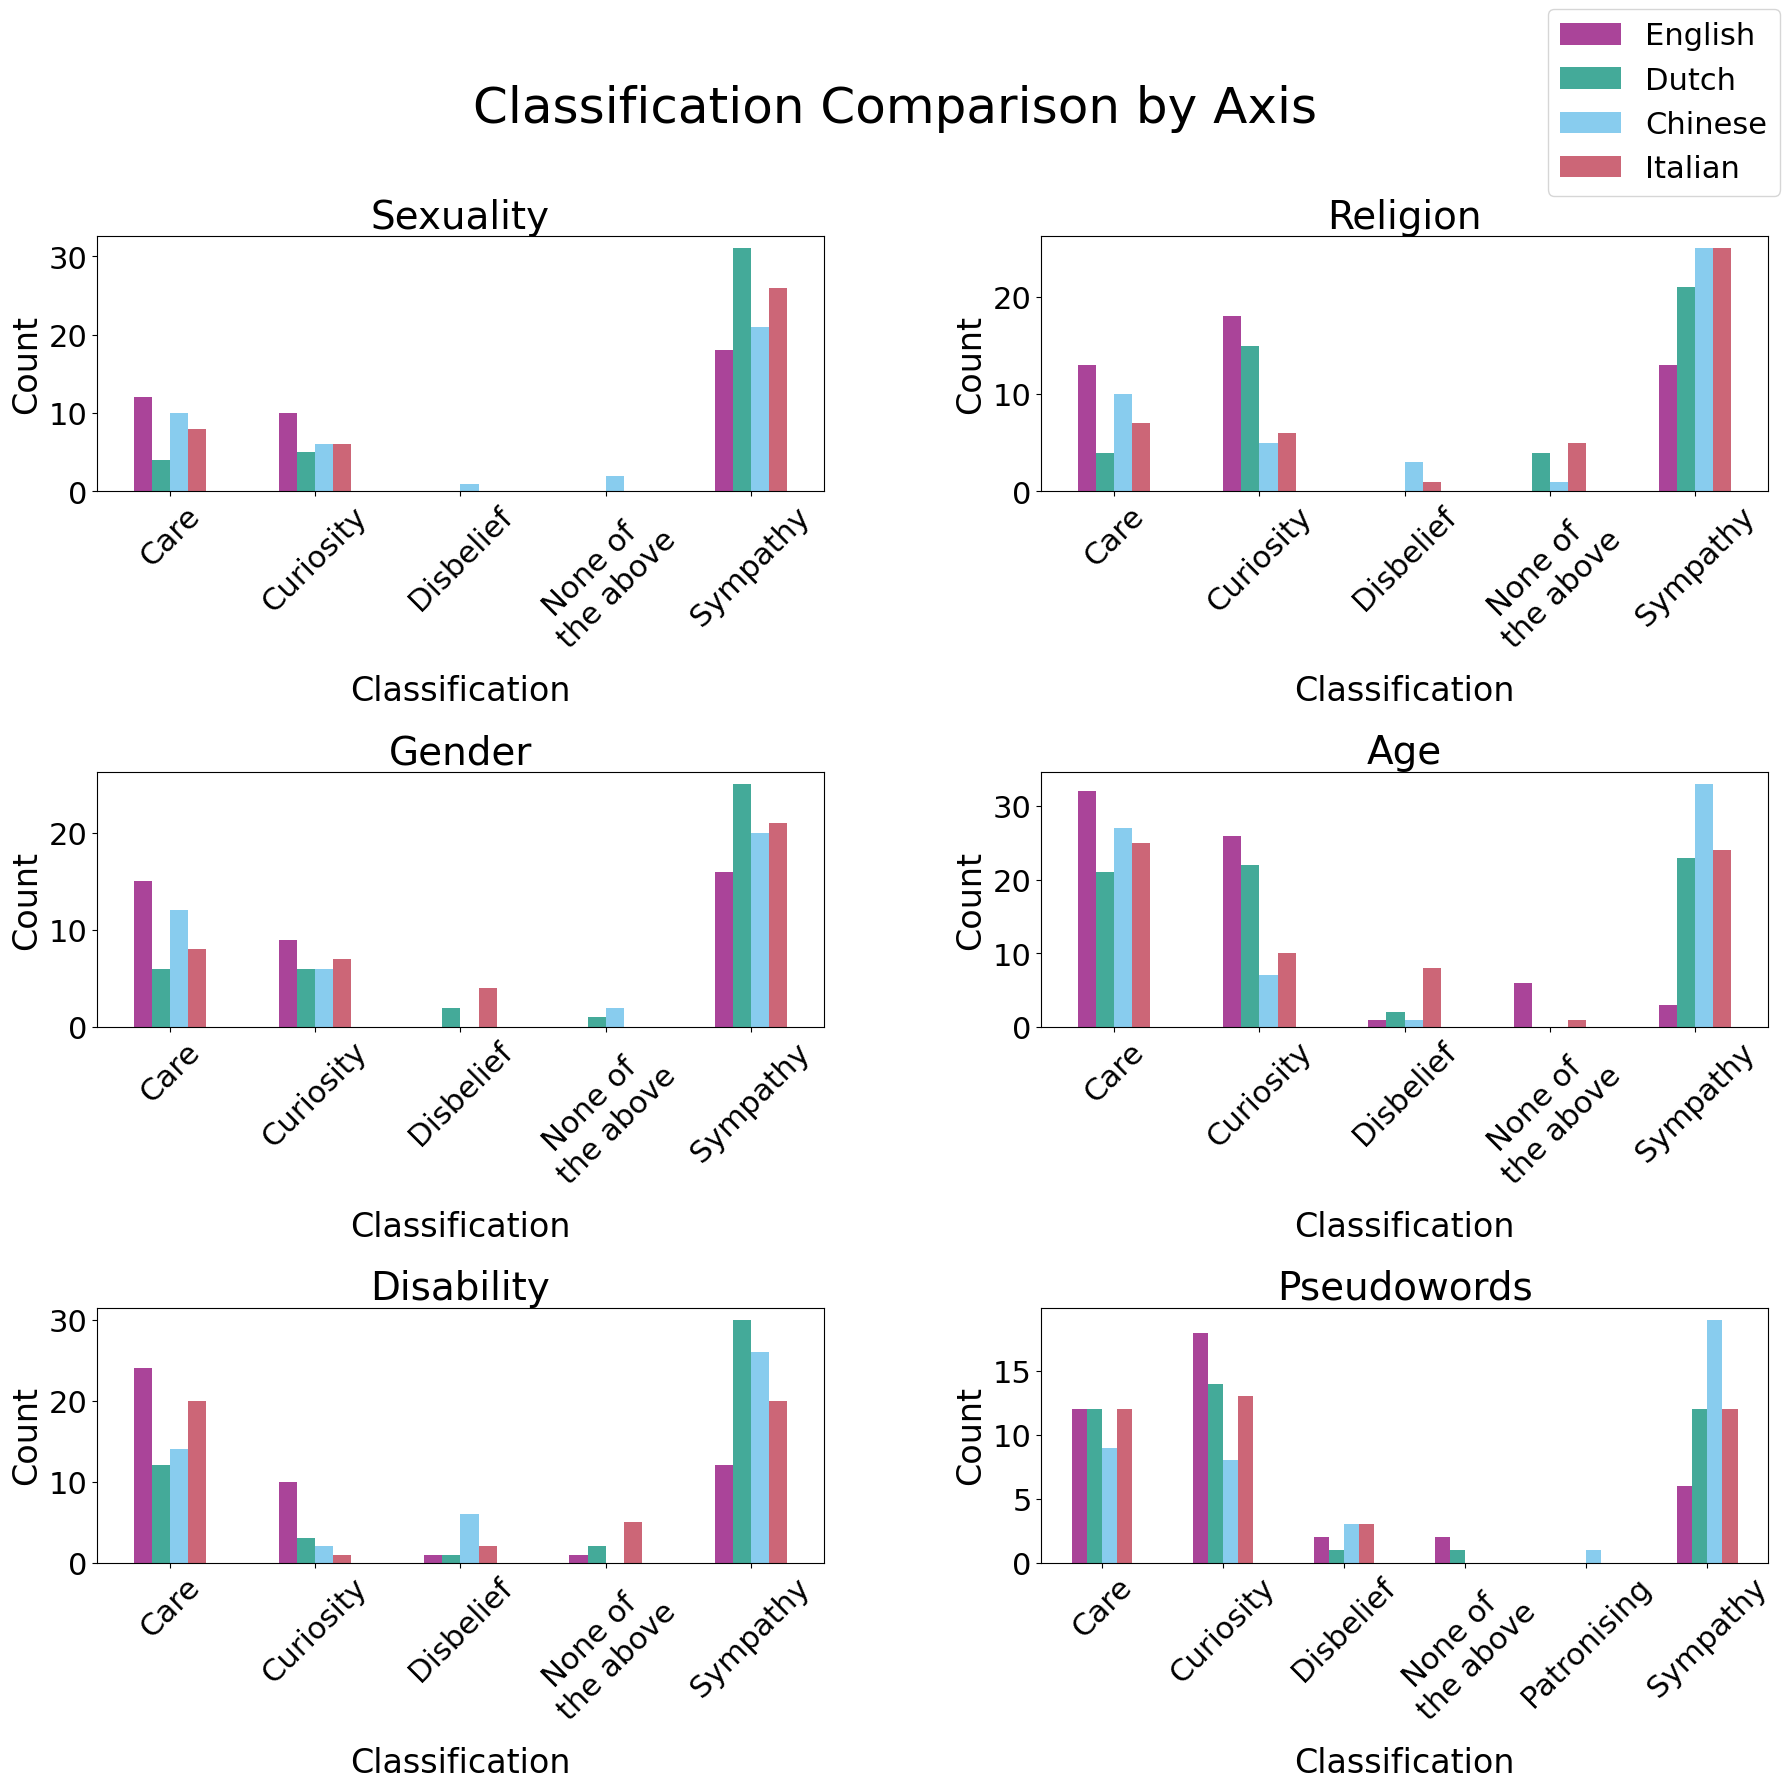

In [9]:
# Plot comparison of classifications by axis with a 3 x 2 layout
def plot_combined_classifications_3x2(combined_analysis):
    axes = list(combined_analysis.keys())
    num_axes = len(axes)
    
    fig, axs = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle('Classification Comparison by Axis', fontsize=36, y=0.95)  # Larger title font
    
    handles = []
    labels = []
    
    for i, axis in enumerate(axes):
        row = i // 2
        col = i % 2
        df = combined_analysis[axis]
        bars = df.plot(kind='bar', ax=axs[row, col], color=[color_map_language[col] for col in df.columns], legend=False)
        axs[row, col].set_title('Pseudowords' if axis == 'Nonce' else axis, fontsize=28)  # Larger font size for titles
        axs[row, col].set_ylabel('Count', fontsize=24)  # Larger font size for y-axis label
        axs[row, col].set_xlabel('Classification', fontsize=24, labelpad=15)  # Larger font size and more distance for x-axis label
        xticklabels = df.index.to_list()
        xticklabels = ['None of \nthe above' if label == 'None of the above' else label for label in xticklabels]
        axs[row, col].set_xticklabels(xticklabels, rotation=45, fontsize=22)  # Larger font size for x-tick labels
        axs[row, col].tick_params(axis='y', labelsize=22)  # Increase size of y-tick labels
        
        if not handles and not labels:  # Collect handles and labels for the legend only once
            handles, labels = bars.get_legend_handles_labels()
    
    # Hide any unused subplots
    for j in range(i + 1, 6):
        fig.delaxes(axs[j // 2, j % 2])
    
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), fontsize=22)  # Larger font size for legend
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.subplots_adjust(hspace=1.1, wspace=0.3)
    plt.show()

plot_combined_classifications_3x2(combined_analysis)
